# Catalogs in IBIS/ISGRI

ISGRI spectral and lightcurve extraction uses a `isgri_srcl_res.fits` catalog result.
The nominal way to get the `isgri_srcl_res.fits` is by running the mosaic (see the [User Guide](https://www.isdc.unige.ch/integral/)). Of course, it is possible to fudge any other catalog in the necessary format (this is done in [MMODA](https://www.astro.unige.ch/mmoda/) when a catalog is generated from json provided by frontend or API), but this fudging is not naturally supported by `OSA` and should be done with a lot of care.

**The reason why the mosaic is need before spectrum** in standard user workflow in OSA is because the spectral extraction quality depends strongly on the catalog - the sky model used for deconstructing the shadowgram. With a wrong catalog, unaccounted source counts will be misattributed to other sources (distorting them) and to background. Due to wide PSFs, sources in some positions overlap substantially. 

Larger part of this note quantifies this effect of "cross-talk" between source counts. Specifically, we will show flux of anysource-of-interest (`SOI`) is modified by unaccounted source flux typically by a fraction of the source count rate, depending on position of both sources. 

## MURA Mask

ISGRI mask has `MURA` pattern (see [doc](https://www.isdc.unige.ch/integral/download/osa/doc/11.2/osa_um_ibis.pdf) and [paper](https://arxiv.org/pdf/astro-ph/0311172.pdf)), whos cyclic autocorrelation is a $\delta$ function. This does not mean, however, that PSF is a $\delta$ function, as it is modified by a several effects. Most of all, within a limited FoV, the auto-correlation develops side-peaks and other symmetric features (they appear as "ghosts"). The FoV is effectively further modified by uneven detector efficiency in FoV.

```{note}
Notably, Swift/BAT and even SVON/ECLAIR do not use MURA mask, and opt for a quasi-random pattern. It may be argued what is actually better: compressing the systematic noise in well-understood regions of data space, or spreading in quasi-randomly. 

Consider how GW detectors compress the noise in resonances, improving the sensitivity elsewhere. 

Clearly, if the location and properties of the regions where the noise is concentrated is poorly understood, the complication is reconstructed.

Another difficulty is that concentrated noise makes some regions largely unaccessible to scientific analysis. If the regions can be moved in different observations, this challenge can be alleviated - this is done in INTEGRAL.
```

One on of the consequences of MURA pattern is that on-axis source is not strongly modified by unaccounted source flux, except if the source is in the PSF side-lobes, which do not occupy large area. So even if at the main PSF side-peak, the contaminating count rate is about 50% of the source, the chance of this event is not large. However, since the PSF orientation depends on the pointing orientation, the PSF overlap occurs very often, resulting in modest average effect.

## Building best input Catalog


The good catalog also allows to produce image - so the process is iterative (image -> catalog -> image -> catalog ... -> catalog -> spectra/lc ). This is the major source of complexity for coded mask analysis (and not only, this applies for every instrument with complex PSF, e.g. Fermi/LAT, or SKA).


General reference catalog is the best global catalog for INTEGRAL, but it is not time-dependent. 
Using only GENREFCAT one often has too many sources in a catalog, and would miss some sources which are only detectable in short outbursts.

So, it is always advisable to produce an catalog for the observation of interest. INTEGRAL General Reference Catalog provides such a general model, with source fluxes indicated.
But, this catalog is static, so it is not really possible to derive sufficiently accurate catalog for given period, considering that over long time, we know that the sources are variable.

In the simplest case, when running spectral extraction directly in one ScW pipeline but it will only rely on the general reference catalog and imaging of this one ScW. This works at minimum, but this is not recommended even at the typical observer level.


We'd need a time-dependent catalog with all sources accounted on all timescales from ScW at least to whole mission. To be clear, to account for all sources, it is necessary to have intermediate timescales (orbit, year, etc).
But it should be clear that this is an enormous task, that's why so much effort goes in production of INTEGRAL catalog papers, and it was never done in an "theoretically ideal" way.
The best approximations of this approach are used in different pipelines, used by us or other people.



So a spectral/lc extraction has to rely on imaging made roughly for the same observation, adding computation.
It also means that typical lightcurves are produced for a variety of effectively equivalent but slightly different catalogs, creating some duplicated lightcurves with slightly different provenance.

With the data collection available now, we can provide the "recommended good" catalogs for spectral extraction at any time.

This could be an extension of REFCAT but with indication of validity of the measurement. If put in a single catalog, it would have millions of rows. This is best handled in a relational DB.

Ultimately, it is better to see the goal in designing a procedure for producing a catalog for given observation. The catalog can be built by querying the collection of available mosaics and providing the current best guess. The collection would have some 10k rows, and can be queried from an available store.

* quality of reconstruction - detector and sky space residuals
* and background properties

In [2]:
# adopted from  https://renkulab.io/projects/vladimir.savchenko/integral-ref-cat/files/blob/catsearch.ipynb


import numpy as np
import astropy
import astropy.coordinates

cat = astropy.io.fits.open("http://isdcarc.unige.ch/arc/rev_3/cat/hec/gnrl_refr_cat_0043.fits")
cat_table = cat[1].data
cat_coord = astropy.coordinates.SkyCoord(cat[1].data['RA_OBJ'], cat[1].data['DEC_OBJ'], unit='deg')

len(cat_table)

2410

In [3]:
maskmod = astropy.io.fits.open("http://isdcarc.unige.ch/arc/rev_3/ic/ibis/mod/isgr_mask_mod_0004.fits")

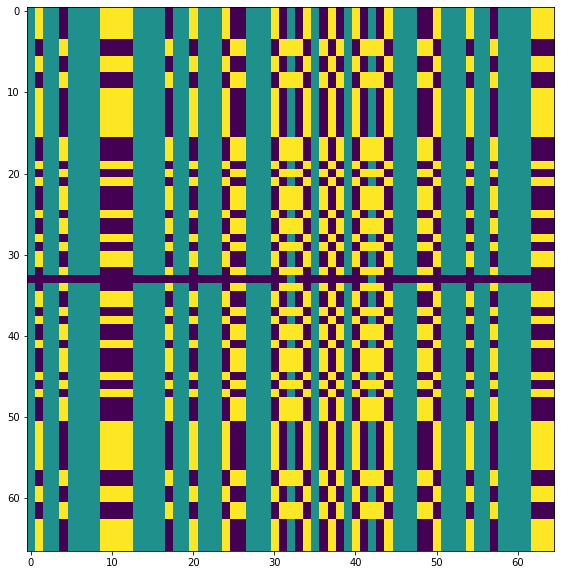

In [4]:
from matplotlib import pylab as plt

maskmap = maskmod[1].data

def pif(src_i, src_j):
    m = np.zeros_like(maskmap)
    m[src_i:,src_j:] = maskmap[:m.shape[0] - src_i,:m.shape[1] - src_j]
    return m[int(m.shape[0]/2-134/2/2):int(m.shape[0]/2+134/2/2), int(m.shape[1]/2-130/2/2):int(m.shape[1]/2+130/2/2)]


plt.figure(figsize=(10,10))

# plt.imshow(maskmap)
plt.imshow(pif(0,0) + pif(0,10) )

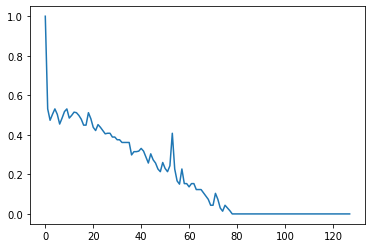

In [5]:
c = []

p1 = pif(0,0)

for i in range(128):
    p2 = pif(0,i)

    c.append(np.sum(p1 * p2) / np.sum(p1**2))
    
plt.figure()

plt.plot(c)

In [14]:
I, J = 40, 40
C = 100
Cm = 50
B = 1000


import time
import scipy
import scipy.stats

def sky_model(i_j_counts, bkg_const):
    model = np.zeros_like(pif(0,0)) + bkg_const

    for i, j, c in i_j_counts:
        model += c*pif(i, j)

    return model

def sky_realization(i_j_counts, bkg_const):    
    return scipy.stats.poisson.rvs(sky_model(i_j_counts, bkg_const))

def sky_reconstruction(i_j_counts, bkg_const, i_j_counts_model):
    sky = sky_realization(i_j_counts, bkg_const)

    def m2LL(reconstructed_counts):
        # print("try", reconstructed_counts)
        return -2*np.sum(scipy.stats.poisson.logpmf(
            sky,
            sky_model([[i, j, r_c] for (i, j, c), r_c in zip(i_j_counts_model, reconstructed_counts[:-1])], 
                    reconstructed_counts[-1]),
                      ))

    return scipy.optimize.minimize(m2LL, [c for i, j, c in i_j_counts_model] + [bkg_const])
            

# plt.figure(figsize=(10, 10))

# plt.imshow(sky_realization(
#     [
#         [0, 0, 100],
#         [10, 10, 50]
#     ],
#     100
# ))


def missing_source_bias(i_j_counts, bkg_const):
    normal = sky_reconstruction(i_j_counts, bkg_const, i_j_counts).x
    biased = sky_reconstruction(i_j_counts, bkg_const, i_j_counts[:-1]).x
    # print(r)
    return biased[0]/normal[0], biased[1]/normal[1]

width = 70

scan = []
plan = []

# on-axis 50%
# need to see corr for two off-set sources too
# try map sources?
# try cross-correlation to reproduce the effect

for i in range(0, width, 1):
    for j in range(0, width, 1):
        plan.append([i, j])
        # print(i, j)

s = 100
t0 = time.time()
for n, (i, j) in enumerate(plan):        
    p = int(100*n/len(plan))
    if p%10 == 0 and s != p:
        print(p, i, j, time.time() - t0)
        s = p

    scan.append([i, j, missing_source_bias(
        [
            [I, J, C],
            [i, j, Cm]
        ],
        B,
    )])
    # scipy.stats.uniform.rvs(0, 1*width, size=100)]

0 0 0 0.0001957416534423828
10 7 0 83.29492998123169
20 14 0 163.82632303237915
30 21 0 244.76879262924194
40 28 0 326.3189232349396
50 35 0 407.48397970199585
60 42 0 492.03356194496155
70 49 0 578.9144332408905
80 56 0 675.469306230545
90 63 0 763.5051593780518


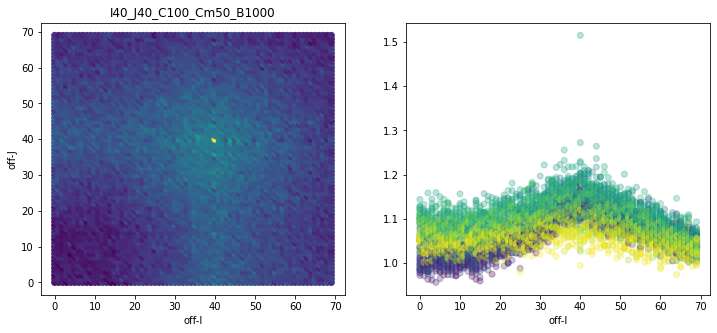

In [15]:
import os

tag = f"I{I}_J{J}_C{C}_Cm{Cm}_B{B}"
base = "catalog-study"
os.makedirs(base, exist_ok=True)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(
    [i for i, j, (b1, b2) in scan],
    [j for i, j, (b1, b2) in scan],
    # [b1 for i, j, (b1, b2) in scan],
    c=[b1 for i, j, (b1, b2) in scan],
)

ax1.set_xlabel("off-I")
ax1.set_ylabel("off-J")

ax2.scatter(
    [i for i, j, (b1, b2) in scan],
    # [j for i, j, (b1, b2) in scan],
    [b1 for i, j, (b1, b2) in scan],
    c=[j for i, j, (b1, b2) in scan],
    alpha=0.3
)
ax2.set_xlabel("off-I")

ax1.set_title(f"{tag}")


import json
json.dump(scan, open(f"{base}/{tag}.json", "w"))
plt.savefig(f"{base}/{tag}.png")